## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [15]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import torch
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from torch.utils.data import DataLoader

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=9151124c-8764-48ad-8eec-4651e30ac0e9
To: /content/IT_data.h5
100%|██████████| 384M/384M [00:03<00:00, 105MB/s]


'IT_data.h5'

In [16]:
import sys
!{sys.executable} -m pip install gdown h5py

### Load the data

In [17]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [18]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


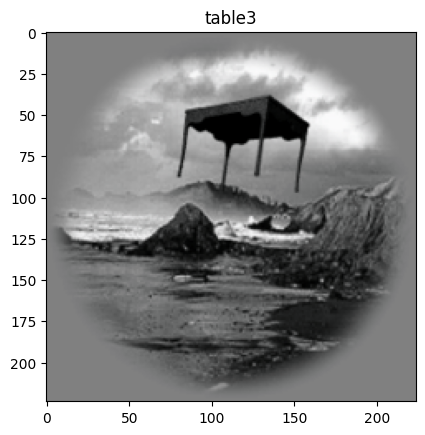

In [19]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

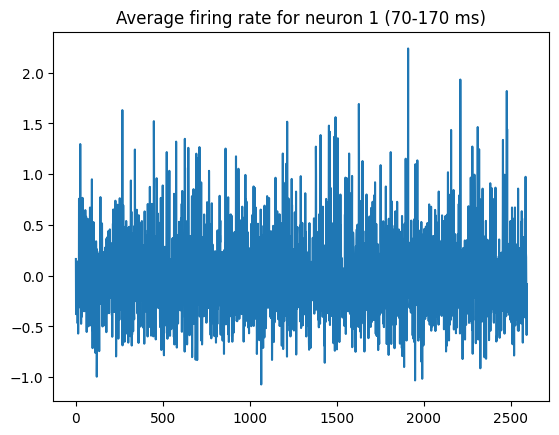

In [20]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [ ]:
from utils import list_to_classes, classes_to_int

def preprocess_data(stimulus_train, stimulus_val, objects_train, objects_val):
    """Function to preprocess data by flattening, normalizing, and augmenting with class labels.

    Args:
        stimulus_train: Training stimulus data (images).
        stimulus_val: Validation stimulus data (images).
        objects_train: Training object labels.
        objects_val: Validation object labels.

    Returns:
        X_train_augmented: Preprocessed and augmented training data.
        X_val_augmented: Preprocessed and augmented validation data.
    """
    # Transform object classes
    objects_train_classes = list_to_classes(objects_train)
    objects_val_classes = list_to_classes(objects_val)

    objects_train_int = classes_to_int(objects_train_classes)
    objects_val_int = classes_to_int(objects_val_classes)

    # Preprocess data (flatten and normalize)
    X_train = stimulus_train.reshape(stimulus_train.shape[0], -1) / 255.0
    X_val = stimulus_val.reshape(stimulus_val.shape[0], -1) / 255.0

    # Append the transformed class labels as additional features
    X_train_augmented = np.hstack((X_train, np.array(objects_train_int).reshape(-1, 1)))
    X_val_augmented = np.hstack((X_val, np.array(objects_val_int).reshape(-1, 1)))

    return X_train_augmented, X_val_augmented

In [ ]:
from sklearn.metrics import explained_variance_score
from utils import compute_corr

def train_and_evaluate(model, model_name, X_train, X_val, spikes_train, spikes_val):
    """Function to train and evaluate a regression model.

    Args:
        model: regression model
        model_name: name of the model
        X_train: training data (features)
        X_val: validation data (features)
        spikes_train: training data (target neural activity)
        spikes_val: validation data (target neural activity)
    """
    print(f"Training {model_name}:")
    model.fit(X_train, spikes_train)

    # Make predictions using validation set
    y_pred = model.predict(X_val)

    # Compute explained variance
    ev_per_neuron = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
    overall_ev = np.mean(ev_per_neuron)
    print(f'Overall explained variance:', overall_ev)

    # Compute correlation between predicted values and real values
    corr_per_neuron = compute_corr(spikes_val, y_pred, divide=True)
    overall_corr = compute_corr(spikes_val, y_pred)
    print(f'Overall correlation:', overall_corr)

    # Plot histograms for explained variance and correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram of explained variance per neuron
    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title(f'{model_name} - Explained variance per neuron')
    axs[0].set_xlabel('Explained variance')
    axs[0].set_ylabel('Frequency')

    # Histogram of correlation per neuron
    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title(f'{model_name} - Correlation per neuron')
    axs[1].set_xlabel('Correlation coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

Training Ridge Regression:
Overall explained variance: 0.09528300198675536
Overall correlation: 0.2932040581296196


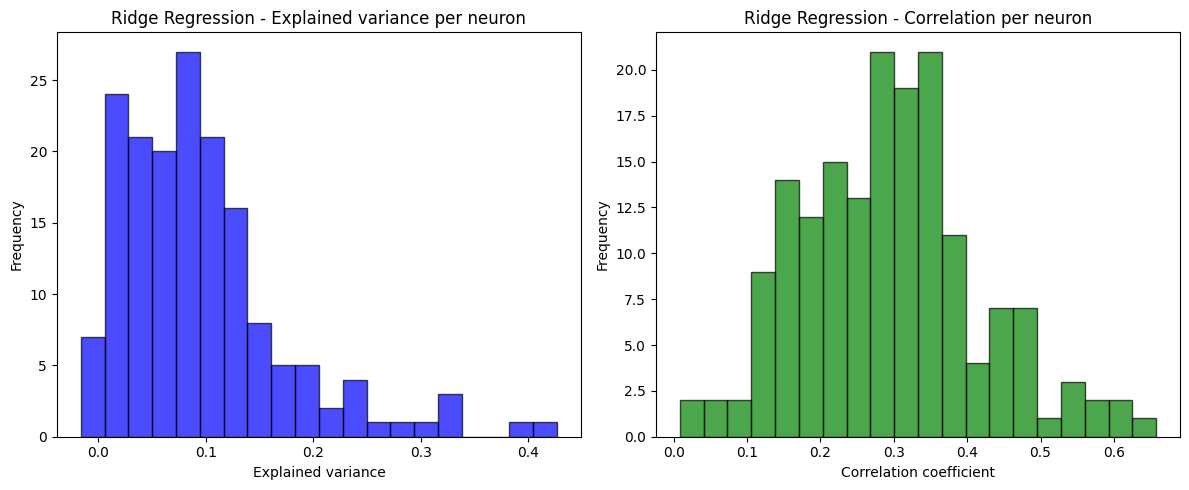

In [10]:
from sklearn.linear_model import Ridge, LinearRegression

# Preprocess data
X_train_augmented, X_val_augmented = preprocess_data(stimulus_train, stimulus_val, objects_train, objects_val)

# Train and evaluate Ridge Regression
ridge = Ridge(alpha=10, fit_intercept=True)
train_and_evaluate(ridge, "Ridge Regression", X_train_augmented, X_val_augmented, spikes_train, spikes_val)

# Train and evaluate Least-Square Regression
# least_squares = LinearRegression(fit_intercept=True)
# train_and_evaluate(least_squares, "Least-Square Regression", X_train_augmented, X_val_augmented, spikes_train, spikes_val)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity.

In [ ]:
from sklearn.decomposition import PCA

# Function to preprocess data with PCA
def preprocess_data_pca(stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000):
    """Function to preprocess data by applying PCA, normalizing, and augmenting with class labels.

    Args:
        stimulus_train: Training stimulus data (images).
        stimulus_val: Validation stimulus data (images).
        objects_train: Training object labels.
        objects_val: Validation object labels.
        n_components: Number of principal components to retain.

    Returns:
        X_train_augmented: Preprocessed and augmented training data.
        X_val_augmented: Preprocessed and augmented validation data.
    """
    # Transform object classes
    objects_train_classes = list_to_classes(objects_train)
    objects_val_classes = list_to_classes(objects_val)

    objects_train_int = classes_to_int(objects_train_classes)
    objects_val_int = classes_to_int(objects_val_classes)

    # Preprocess data (flatten and normalize)
    X_train = stimulus_train.reshape(stimulus_train.shape[0], -1) / 255.0
    X_val = stimulus_val.reshape(stimulus_val.shape[0], -1) / 255.0

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    print(f"PCA complete. Explained variance ratio (first {n_components} PCs): {np.sum(pca.explained_variance_ratio_):.2f}\n")

    # Append the transformed class labels as additional features
    X_train_augmented = np.hstack((X_train_pca, np.array(objects_train_int).reshape(-1, 1)))
    X_val_augmented = np.hstack((X_val_pca, np.array(objects_val_int).reshape(-1, 1)))

    return X_train_augmented, X_val_augmented

PCA complete. Explained variance ratio (first 1000 PCs): 0.98

Training Ridge regression with PCA:
Overall explained variance: 0.09476526060716306
Overall correlation: 0.2920954545949086


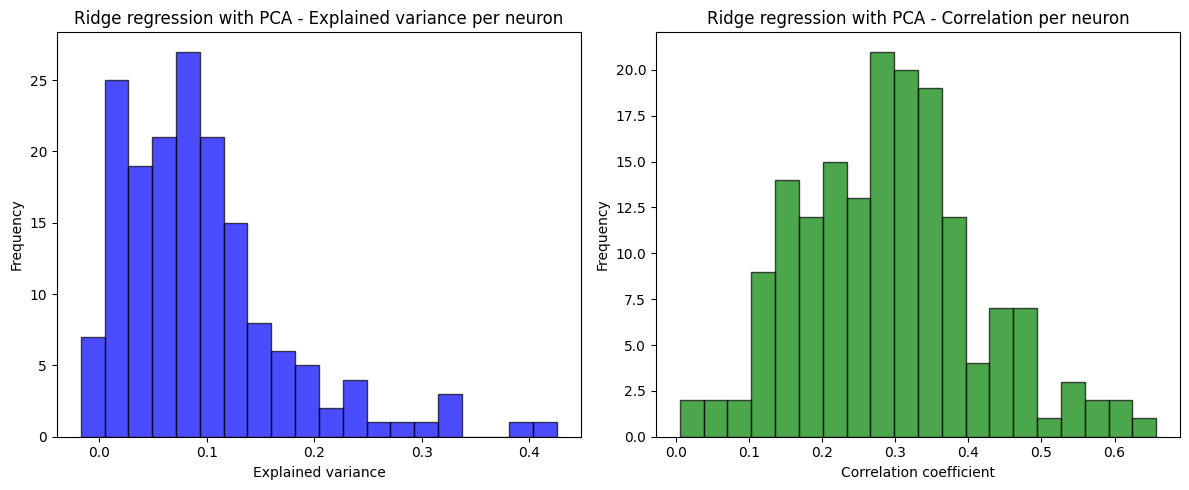

In [12]:
# Preprocess data with PCA
X_train_augmented_pca, X_val_augmented_pca = preprocess_data_pca(stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000)

# Train and evaluate Ridge Regression with PCA
ridge = Ridge(alpha=10, fit_intercept=True)
train_and_evaluate(ridge, "Ridge regression with PCA", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

# Train and evaluate Least-Square Regression with PCA
# least_squares = LinearRegression(fit_intercept=True)
# train_and_evaluate(least_squares, "Least-square regression with PCA", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

---
### _Discussion_
The results indicate that the first 1000 principal components (PCs) capture nearly all the variance explained by the model. Specifically, the overall explained variance is **0.09478**, compared to the original value of **0.09528**, and the overall correlation is **0.2922**, compared to the original value of **0.2932**.

This minimal difference suggests that the additional PCs beyond the first 1000 contribute very little to the model's performance. Therefore, **reducing the dimensionality to the first 1000 PCs may be a reasonable trade-off between model complexity and performance**.

---

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_ridge(X, y, objects, alphas, n_splits=5):
    """Perform cross-validation to find the best alpha for Ridge Regression.

    Args:
        X: Feature matrix.
        y: Target matrix (neural activity).
        objects: Class labels for stratification.
        alphas: List of alpha values to test.
        n_splits: Number of cross-validation splits.

    Returns:
        best_alpha: The alpha value that gives the best performance.
    """
    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        ridge = Ridge(alpha=alpha, fit_intercept=True)
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        fold_scores = []
        for train_idx, val_idx in skf.split(X, objects):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Train Ridge Regression
            ridge.fit(X_train, y_train)

            # Predict and evaluate explained variance
            y_pred = ridge.predict(X_val)
            ev_per_neuron = explained_variance_score(y_val, y_pred, multioutput='raw_values')
            fold_scores.append(np.mean(ev_per_neuron))

        # Average score across folds
        mean_score = np.mean(fold_scores)
        print(f"alpha={alpha}, mean explained variance: {mean_score:.4f}")

        # Update best alpha if this one is better
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha

    print(f"\nBest alpha: {best_alpha} with mean explained variance: {best_score:.4f} \n")
    return best_alpha

PCA complete. Explained variance ratio (first 1000 PCs): 0.98

alpha=1, mean explained variance: 0.0646
alpha=2, mean explained variance: 0.0807
alpha=5, mean explained variance: 0.0874
alpha=10, mean explained variance: 0.0861
alpha=15, mean explained variance: 0.0836
alpha=30, mean explained variance: 0.0768
alpha=100, mean explained variance: 0.0595
alpha=1000, mean explained variance: 0.0274

Best alpha: 5 with mean explained variance: 0.0874 

Training Ridge regression with PCA (alpha=5):
Overall explained variance: 0.09679764940544189
Overall correlation: 0.29303748268134633


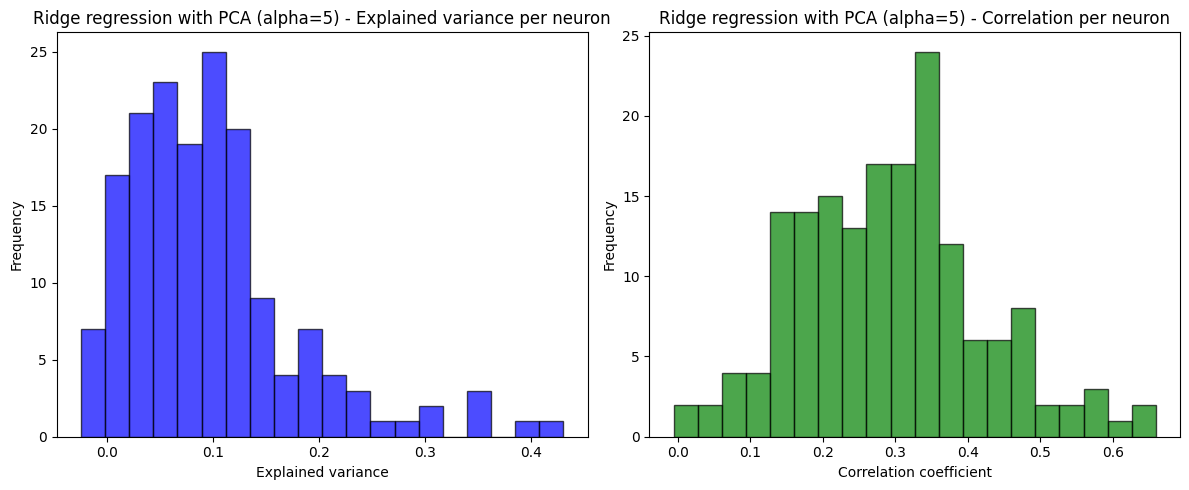

In [14]:
# Preprocess data with PCA
X_train_augmented_pca, X_val_augmented_pca = preprocess_data_pca(
    stimulus_train, stimulus_val, objects_train, objects_val, n_components=1000
)

# Combine train and validation data for cross-validation
X_combined = np.vstack((X_train_augmented_pca, X_val_augmented_pca))
y_combined = np.vstack((spikes_train, spikes_val))
objects_combined = np.hstack((objects_train, objects_val))

# Perform cross-validation to find the best alpha
alphas = [1, 2, 5, 10, 15, 30, 100, 1000]
best_alpha = cross_validate_ridge(X_combined, y_combined, objects_combined, alphas)

# Train and evaluate Ridge Regression with the best alpha
ridge = Ridge(alpha=best_alpha, fit_intercept=True)
train_and_evaluate(ridge, f"Ridge regression with PCA (alpha={best_alpha})", X_train_augmented_pca, X_val_augmented_pca, spikes_train, spikes_val)

---
### _Discussion_
We observe a slight improvement in prediction performance by using cross-fold validation to optimize the alpha parameter for ridge regression. With the best alpha value of **5**, the overall explained variance increases from **0.09478** to **0.09680**, and the overall correlation improves from **0.2921** to **0.2930** (compared to the original alpha value of **10**).

However, despite these efforts, the improvement in explained variance and correlation is minimal. This suggests that **the model struggles to generalize effectively to new data.** The principal reason is the **model complexity:** the ridge regression model may not be expressive enough to capture the underlying patterns in the data.

---

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [24]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### _Custom Stimuli Dataset Class Definition_

In [ ]:
class StimuliDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading visual stimuli and optional neural response data.

    Parameters
    ----------
    stimuli : np.ndarray or list
        A collection of image stimuli, expected as a NumPy array or list of arrays.
    responses : np.ndarray or list, optional
        Corresponding neural response vectors for each stimulus. If None, dataset returns only stimuli.
    transform : callable, optional
        A function/transform to apply to each stimulus (e.g., normalization).

    Methods
    -------
    __len__():
        Returns the number of samples in the dataset.

    __getitem__(idx):
        Returns the transformed stimulus and corresponding response (if available) at the given index.
    """

    def __init__(self, stimuli, responses=None, transform=None):
        self.stimuli = stimuli
        self.responses = responses
        self.transform = transform

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        x = self.stimuli[idx]
        if self.transform:
            x = self.transform(torch.tensor(x).float())
        return (x, self.responses[idx]) if self.responses is not None else x

### _Data Preparation: Datasets, Transforms, and DataLoaders_

In [ ]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = StimuliDataset(stimulus_train, spikes_train, transform=transform)
val_dataset = StimuliDataset(stimulus_val, spikes_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

### _Activation Extraction Utility Function_

In [ ]:
def extract_activations(model, loader, layer_name):
    """
    Extracts and flattens activations from a specified layer of a model for all inputs in a DataLoader.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model from which to extract activations.
    loader : torch.utils.data.DataLoader
        DataLoader providing input data in batches.
    layer_name : str
        Name of the layer (as registered in model.named_modules()) to hook and extract activations from.

    Returns
    -------
    np.ndarray
        A NumPy array of shape (N, D) where N is the number of samples and D is the flattened activation dimension
        from the specified layer.
    """
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach().cpu().numpy().reshape(output.size(0), -1))

    hook = dict(model.named_modules())[layer_name].register_forward_hook(hook_fn)

    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            _ = model(imgs)

    hook.remove()

    return np.concatenate(activations, axis=0)


### _Layer-wise Evaluation: PCA + Linear Regression on Pretrained ResNet50_

In [ ]:
model = models.resnet50(pretrained=True).to(device).eval()

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
results = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act = extract_activations(model, train_loader, layer)
    val_act = extract_activations(model, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act.shape[1])
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pcs = pca.fit_transform(train_act)
    X_val_pcs = pca.transform(val_act)

    # Linear Regression
    lr = LinearRegression().fit(X_train_pcs, spikes_train)
    preds_val = lr.predict(X_val_pcs)

    # Evaluation metrics
    ev = explained_variance_score(spikes_val, preds_val)
    correlations = [pearsonr(spikes_val[:, i], preds_val[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr = np.mean(correlations)

    results[layer] = {'explained_variance': ev, 'mean_correlation': avg_corr}

    print(f"{layer} | EV: {ev:.4f}, Mean Corr: {avg_corr:.4f}")
    

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing conv1
conv1 | EV: -0.0290, Mean Corr: 0.2378
Processing layer1
layer1 | EV: 0.2081, Mean Corr: 0.4678
Processing layer2
layer2 | EV: 0.2208, Mean Corr: 0.4848
Processing layer3
layer3 | EV: 0.2598, Mean Corr: 0.5213
Processing layer4
layer4 | EV: 0.1903, Mean Corr: 0.4752
Processing avgpool
avgpool | EV: -0.0780, Mean Corr: 0.3395


### _Comments on results_
This show how well different layers of a pretrained ResNet50 explain neural activity in the brain, using **explained variance (EV)** and **mean Pearson correlation (Corr)** between predicted and actual neural responses.

---

#### **Summary of Layer-wise Results**

| Layer     | Explained Variance (EV) | Mean Correlation (Corr) | Interpretation |
|-----------|--------------------------|--------------------------|----------------|
| `conv1`   | -0.0290                  | 0.2378                   | Very low predictive power. Negative EV means it's worse than predicting the mean. |
| `layer1`  | 0.2081                   | 0.4678                   | Substantial increase. Early convolutional features begin to capture meaningful structure. |
| `layer2`  | 0.2208                   | 0.4848                   | Slight improvement. Feature complexity increases; more aligned with neural coding. |
| `layer3`  | **0.2598**               | **0.5213**               | **Peak performance**. Captures mid-level representations similar to IT cortex. |
| `layer4`  | 0.1903                   | 0.4752                   | Drop in EV and Corr. Possibly due to over-compression or task-specific abstraction. |
| `avgpool` | -0.0780                  | 0.3395                   | Sharp drop. Final layer is highly task-optimized (e.g., for classification), discarding variance needed for regression. |

---

#### **Interpretation**

- **Best-performing layer:** `layer3`, both in EV and correlation. This supports the idea that **mid-to-deep layers** in CNNs most closely match the representational geometry of high-level visual areas like IT.
  
- **Decline in deeper layers:** The drop in performance at `layer4` and especially `avgpool` suggests that later layers become increasingly abstract and invariant — optimized for classification rather than preserving detailed variance in neural firing patterns.

- **Early layers insufficient:** `conv1` performs poorly. This is expected — low-level features like edges or textures don’t carry the complexity needed to explain IT neuron responses.

---

#### **Conclusion**

These results align well with the idea that **task-trained CNNs best approximate brain activity at intermediate depths**, where abstract yet not fully class-specific features are most prominent. The **non-monotonic trend** (rising then falling) is characteristic of both artificial and biological hierarchies.

### _Layer-wise Evaluation: PCA + Linear Regression on Randomly Initialized ResNet50_

In [ ]:
model_rand = models.resnet50(pretrained=False).to(device).eval()

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
results_rand  = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_rand = extract_activations(model_rand, train_loader, layer)
    val_act_rand  = extract_activations(model_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand .shape[1])
    pca_rand  = PCA(n_components=n_components, random_state=42)
    X_train_pcs_rand  = pca_rand .fit_transform(train_act_rand)
    X_val_pcs_rand  = pca_rand .transform(val_act_rand)

    # Linear Regression
    lr_rand  = LinearRegression().fit(X_train_pcs_rand , spikes_train )
    preds_val_rand  = lr_rand .predict(X_val_pcs_rand )

    # Evaluation metrics
    ev_rand  = explained_variance_score(spikes_val, preds_val_rand )
    correlations_rand  = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_rand  = np.mean(correlations_rand )

    results_rand[layer] = {'explained_variance': ev_rand, 'mean_correlation': avg_corr_rand}

    print(f"{layer} | EV: {ev_rand:.4f}, Mean Corr: {avg_corr_rand:.4f}")
    

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing conv1
conv1 | EV: -0.0833, Mean Corr: 0.2172
Processing layer1
layer1 | EV: 0.1301, Mean Corr: 0.4025
Processing layer2
layer2 | EV: 0.1689, Mean Corr: 0.4302
Processing layer3
layer3 | EV: 0.1547, Mean Corr: 0.4200
Processing layer4
layer4 | EV: 0.1226, Mean Corr: 0.3976
Processing avgpool
avgpool | EV: -0.0686, Mean Corr: 0.3262


### _Layer-wise Performance Comparison: Pretrained vs Random (EV & Correlation)_

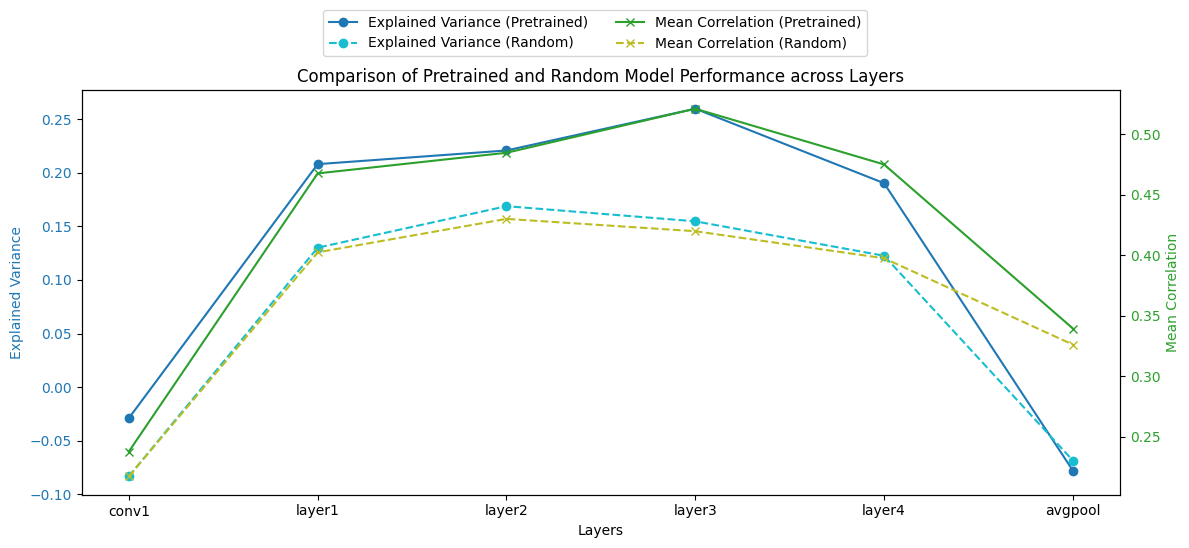

In [ ]:
layers_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

explained_vars_pre = [results[layer]['explained_variance'] for layer in layers_labels]
correlations_pre = [results[layer]['mean_correlation'] for layer in layers_labels]
explained_vars_rand = [results_rand[layer]['explained_variance'] for layer in layers_labels]
correlations_rand = [results_rand[layer]['mean_correlation'] for layer in layers_labels]

fig, ax1 = plt.subplots(figsize=(12, 5))

# Explained Variance (left axis)
color_ev_pre = 'tab:blue'
color_ev_rand = 'tab:cyan'
ax1.set_xlabel('Layers')
ax1.set_ylabel('Explained Variance', color=color_ev_pre)
ax1.plot(layers_labels, explained_vars_pre, color=color_ev_pre, marker='o', label='Explained Variance (Pretrained)')
ax1.plot(layers_labels, explained_vars_rand, color=color_ev_rand, marker='o', linestyle='--', label='Explained Variance (Random)')
ax1.tick_params(axis='y', labelcolor=color_ev_pre)

# Mean Correlation (right axis)
ax2 = ax1.twinx()
color_corr_pre = 'tab:green'
color_corr_rand = 'tab:olive'
ax2.set_ylabel('Mean Correlation', color=color_corr_pre)
ax2.plot(layers_labels, correlations_pre, color=color_corr_pre, marker='x', label='Mean Correlation (Pretrained)')
ax2.plot(layers_labels, correlations_rand, color=color_corr_rand, marker='x', linestyle='--', label='Mean Correlation (Random)')
ax2.tick_params(axis='y', labelcolor=color_corr_pre)

# Legends
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.title('Comparison of Pretrained and Random Model Performance across Layers')
fig.tight_layout()
plt.show()

- **Pretrained > Random** at all layers — task training improves neural prediction.  
- **Best layer: `layer3`** — aligns most with IT cortex.  
- **`avgpool` drops** — overcompressed, class-specific.  
- **Random model weak overall**, slight peak at mid-layers.

### _Neuron-Level Performance Distribution: Pretrained vs Random_

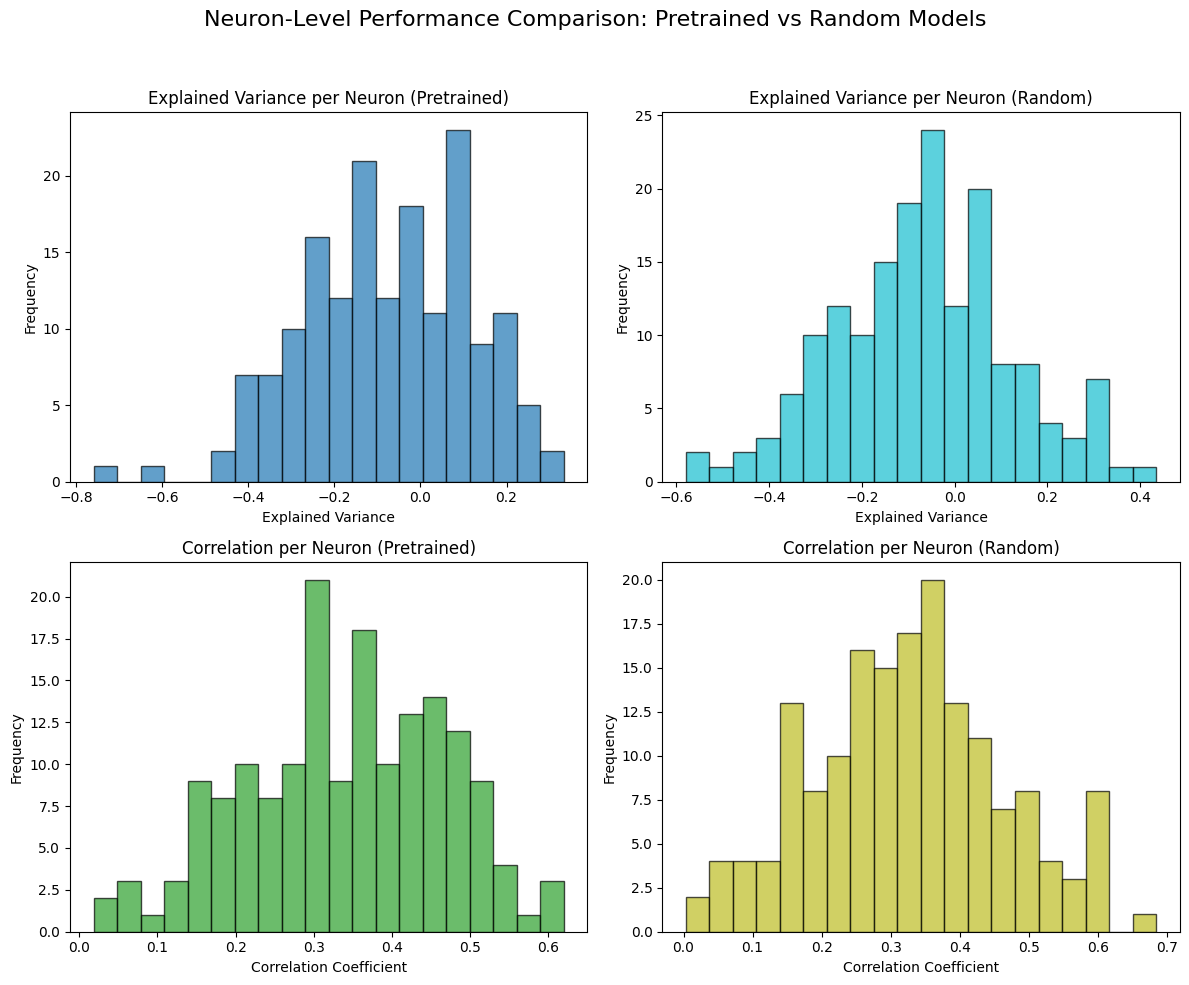

In [42]:
# Calculate per-neuron metrics
explained_variance_per_neuron_pre = 1 - np.var(spikes_val - preds_val, axis=0) / np.var(spikes_val, axis=0)
correlation_per_neuron_pre = [pearsonr(spikes_val[:, i], preds_val[:, i])[0] for i in range(spikes_val.shape[1])]

explained_variance_per_neuron_rand = 1 - np.var(spikes_val - preds_val_rand, axis=0) / np.var(spikes_val, axis=0)
correlation_per_neuron_rand = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]

# Plot histograms for comparison
fig, axs = plt.subplots(2, 2, figsize=(1 2, 10))

# Explained Variance per neuron
axs[0, 0].hist(explained_variance_per_neuron_pre, bins=20, color='tab:blue', alpha=0.7, edgecolor='black')
axs[0, 0].set_title('Explained Variance per Neuron (Pretrained)')
axs[0, 0].set_xlabel('Explained Variance')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(explained_variance_per_neuron_rand, bins=20, color='tab:cyan', alpha=0.7, edgecolor='black')
axs[0, 1].set_title('Explained Variance per Neuron (Random)')
axs[0, 1].set_xlabel('Explained Variance')
axs[0, 1].set_ylabel('Frequency')

# Correlation per neuron
axs[1, 0].hist(correlation_per_neuron_pre, bins=20, color='tab:green', alpha=0.7, edgecolor='black')
axs[1, 0].set_title('Correlation per Neuron (Pretrained)')
axs[1, 0].set_xlabel('Correlation Coefficient')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(correlation_per_neuron_rand, bins=20, color='tab:olive', alpha=0.7, edgecolor='black')
axs[1, 1].set_title('Correlation per Neuron (Random)')
axs[1, 1].set_xlabel('Correlation Coefficient')
axs[1, 1].set_ylabel('Frequency')

plt.suptitle('Neuron-Level Performance Comparison: Pretrained vs Random Models', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

These histograms show **per-neuron explained variance** and **correlation** distributions for pretrained and random models.

---

###  **Explained Variance (Top Row)**
- **Pretrained (left)**: Distribution is **centered slightly above 0**, with some neurons reaching ~0.3. However, many still fall below 0.
- **Random (right)**: Most values are near or **below 0**, showing worse predictive power. Some neurons get positive EV, likely due to noise or chance.

**Conclusion**: The pretrained model offers better neuron-level predictions overall, though the explained variance remains modest. Interestingly, even in the non-pretrained ResNet, certain layers—particularly layers 2 and 3—exhibit relatively high explained variance. This suggests that the architecture of ResNet alone, independent of pretraining, may inherently capture features that align with neural activity to some extent.

---

### **Correlation (Bottom Row)**
- **Pretrained (left)**: Correlations mostly range from **0.2 to 0.5**, peaking around **0.3–0.4**.
- **Random (right)**: Lower overall, with many neurons below **0.3**, peak around **0.25–0.35**.

**Conclusion**: Pretrained model consistently produces higher correlations with neural responses. As for the explain variance, some layers of the non-pretrained ResNet show higher correlation, suggesting that its architecture may inherently capture features that align with neural activit.

---

### Summary
- Pretrained model shows **clear advantages** at the neuron level, though still far from perfect.
- Random model barely captures structure (but some layers still capture some kind of structure) — consistent with lack of task-specific features.
- Neural prediction is **distributed**, with some neurons being much better predicted than others — possibly reflecting differing selectivity or noise levels.